# 소개
* 열화상 **raw** 이미지를 확인할 수 있습니다.
> 오브젝트 bbox 내 **상위 온도**(최고 온도 포함) 픽셀의 분포를 확인할 수 있습니다.
* 시퀀스별 **normal/abnormal** 샘플의 분포를 확인할 수 있습니다.
* 시퀀스 내 상태 변화 샘플의 픽셀 온도를 확인할 수 있습니다.

In [1]:
import os
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json

In [2]:
IMG_WIDTH = 640
IMG_HEIGHT = 512

In [3]:
def check_csv(df_temp):
  if df_temp.shape[0] != IMG_HEIGHT:
    return False
  list_temp = [row[1][0].split(';')[:-1] for row in df_temp.iterrows()]
  for temp in list_temp:
    if len(temp) != IMG_WIDTH:
      return False
  return True

In [4]:
def create_raw_image(sample):
  df_temp = pd.read_csv(sample)[4:].reset_index(drop=True)
  image = np.zeros((IMG_HEIGHT, IMG_WIDTH))
  if check_csv(df_temp):
    for idx, row in df_temp.iterrows():
      image[idx, :] = np.array([float(x) for x in row[0].split(';')[:-1]])
  return image

In [5]:
def get_bbox_info(image, x, y, w, h, num_pixel):
  bbox = []
  bbox_temp = []
  bbox_x = []
  bbox_y = []
  for cy in range(h):
    for cx in range(w):
      coord_x = x+cx
      coord_y = y+cy
      if coord_y < IMG_HEIGHT and coord_x < IMG_WIDTH:
        bbox.append([image[coord_y][coord_x], coord_x, coord_y])
  bbox.sort(reverse=True)
  bbox = bbox[0:num_pixel]
  for b in bbox:
    bbox_temp.append(b[0])
    bbox_x.append(b[1])
    bbox_y.append(b[2])
  bbox_temp.sort(reverse=True)
  return bbox_temp, bbox_x, bbox_y

In [6]:
# list_obj = [[137., 239., 280., 512.],
#             [284., 242., 338., 510.],
#             [373., 234., 490., 512.],
#             [432., 236., 505., 512.]]

In [7]:
def draw_bbox(image, path_label, num_pixel):
  if num_pixel > IMG_WIDTH*IMG_HEIGHT:
    num_pixel = IMG_WIDTH*IMG_HEIGHT
  status = "normal"
  sample_name = os.path.splitext(path_label.split('/')[-1])[0]
  fig, ax = plt.subplots(figsize=(16, 8))
  with open(path_label, "r") as f:
    dict_label = json.load(f)
    for obj in dict_label["annotations"]:
      if obj["attributes"]["status"] != "normal":
        status = '*'+obj["attributes"]["status"]
      x = obj["data"]["x"]
      y = obj["data"]["y"]
      w = obj["data"]["width"]
      h = obj["data"]["height"]
      ax.add_patch(patches.Rectangle((x,y), w, h, linewidth=1, edgecolor='r', facecolor='none'))
      bbox_temp, bbox_x, bbox_y = get_bbox_info(image, x, y, w, h, num_pixel)
      ax.scatter(bbox_x, bbox_y, marker='.', c='red')
  # for obj in list_obj:
  #   x = int(obj[0])
  #   y = int(obj[1])
  #   w = int(obj[2])-x
  #   h = int(obj[3])-y
  #   ax.add_patch(patches.Rectangle((x,y), w, h, linewidth=1, edgecolor='r', facecolor='none'))
  #   bbox_temp, bbox_x, bbox_y = get_bbox_info(image, x, y, w, h, num_pixel)
  #   ax.scatter(bbox_x, bbox_y, marker='.', c='red')
  plt.title(f"[{status}:{max(bbox_temp)}] {sample_name}") 
  ax.imshow(image)

In [8]:
def check_abnormal(sample):
  with open(sample, "r") as f:
    dict_label = json.load(f)   
    for obj in dict_label["annotations"]:
      if obj["attributes"]["status"] != "normal":
        return True
    return False

In [9]:
def get_seqno_id(input_seqno):
  if str(input_seqno) not in list_seqno:
    print(f"존재하지 않는 시퀀스 번호입니다. ({input_seqno})")
    return
  for i, seqno in enumerate(list_seqno):
    if str(input_seqno) == seqno:
      return i

In [10]:
def get_seqno(sample):
  seqno = os.path.splitext(sample.split('/')[-1])[0].split('(')[1].split(')')[0]
  return seqno

In [11]:
def get_frmno(sample):
  filename = sample.split('/')[-1]
  filename_sp = filename.split('(')[-1]
  frmno = filename_sp.split(')')[0]
  return frmno

In [12]:
def get_statno(sample_name):
  sample_name_sp = sample_name.split('(')[-1]
  sample_name_sp = sample_name_sp.split(')')[-1]
  statno = sample_name_sp.split('.')[0]
  return statno

In [13]:
def get_sample_name_pair(sample_name):
  sample_name_sp = sample_name[:-4]
  statno_pair = "0101"
  if get_statno(sample_name) == "0101":
    statno_pair == "0102"
  sample_name_pair = sample_name_sp+statno_pair
  return sample_name_pair

In [14]:
def get_sample_by_frmno(list_sample, frmno):
  next_samples = []
  for sample in list_sample:
    if frmno in sample.split('/')[-1]:
      next_samples.append(sample)
  return next_samples

In [15]:
def get_next_frmno(list_frmno, cur_frmno):
  for i, frmno in enumerate(list_frmno):
    if cur_frmno == frmno:
      if i+1 < len(list_frmno):
        next_frmno = list_frmno[i+1]
        return next_frmno
  return cur_frmno

# 0. 데이터셋 선택



---

🔽 아래 **PATH_DATASET**에 EDA를 수행할 데이터셋의 경로를 입력합니다.

In [16]:
PATH_DATASET ="/content/drive/MyDrive/canAiry/data/00_all_dataset/04-2_TR-gearbox"



---



In [17]:
PATH_CSV = PATH_DATASET + "/00_csv/"
PATH_CSV_TRAIN = PATH_CSV + "train/"
PATH_CSV_VAL = PATH_CSV + "val/"
PATH_CSV_TEST = PATH_CSV + "test/"
PATH_LABEL = PATH_DATASET + "/01_label/"
PATH_LABEL_TRAIN = PATH_LABEL + "train/"
PATH_LABEL_VAL = PATH_LABEL + "val/"
PATH_LABEL_TEST = PATH_LABEL + "test/"

In [18]:
list_csv = glob(PATH_CSV_TRAIN + '*.csv') + glob(PATH_CSV_VAL + '*.csv') + glob(PATH_CSV_TEST + '*.csv')
list_label = glob(PATH_LABEL_TRAIN + '*.json') + glob(PATH_LABEL_VAL + '*.json') + glob(PATH_LABEL_TEST + '*.json')

# 1. **Raw 이미지** 확인

[ 함수 인자 설명 ]
* '**sample**' ➡ 샘플 csv 파일의 경로
* '**num_pixel**' ➡ 표시하고자하는 상위 온도 픽셀의 수

In [19]:
def show_raw_image(sample, num_pixel):
  label = sample.split('.')[0].replace('00_csv','01_label')+'.json'
  draw_bbox(create_raw_image(sample), label, num_pixel)

⭐ 사용 예시

In [20]:
path_sample = "/content/drive/MyDrive/canAiry/data/02_2nd-dataset/04-1_TR-bearing/00_csv/train/0401011028(1241)R(0484)0101.csv"

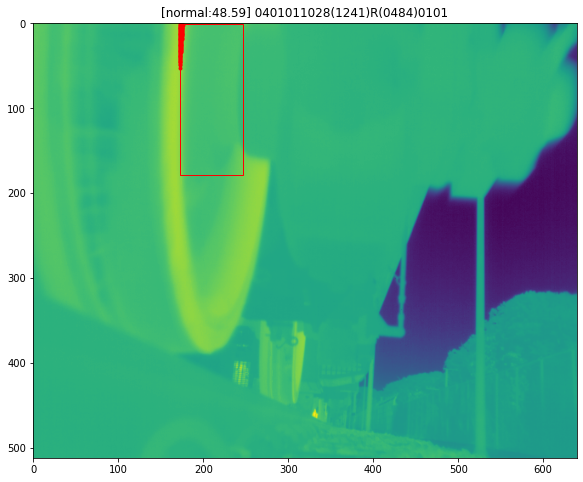

In [23]:
show_raw_image(path_sample, 100)

# 2. 시퀀스별 **샘플 분포**

> 'abnormal' 샘플을 구분합니다.

In [ ]:
list_abnormal = []
for label in tqdm(list_label):
  sample_name = os.path.splitext(label.split('/')[-1])[0]
  with open(label, "r") as f:
    dict_label = json.load(f)
    for obj in dict_label["annotations"]:
      if obj["attributes"]["status"] != "normal":
        list_abnormal.append(sample_name)
        break

100%|██████████| 24525/24525 [4:46:38<00:00,  1.43it/s]


> 샘플을 시퀀스별로 구분한 dictionary를 생성합니다. 

In [ ]:
list_seqno = [get_seqno(csv) for csv in list_csv]
list_seqno = list(set(list_seqno))
list_seqno.sort()

In [ ]:
dict_sample = dict(zip(list_seqno, [[] for i in range(len(list_seqno))]))
for csv in list_csv:
  for i, seqno in enumerate(list_seqno):
    if os.path.splitext(csv.split('/')[-1])[0].split('(')[1].split(')')[0] == seqno:
      dict_sample[list_seqno[i]].append(csv)

In [ ]:
for i in range(len(list_seqno)):
  num_abnormal = 0
  for sample in dict_sample[list_seqno[i]]:
    sample_name = os.path.splitext(str(sample).split('/')[-1])[0]
    if sample_name in list_abnormal:
      num_abnormal += 1
  dict_sample[list_seqno[i]].append(num_abnormal)

In [ ]:
dict_seqno = dict(zip(list_seqno, [[len(dict_sample[list_seqno[i]][:-1])-dict_sample[list_seqno[i]][-1], dict_sample[list_seqno[i]][-1]] for i in range(len(list_seqno))]))

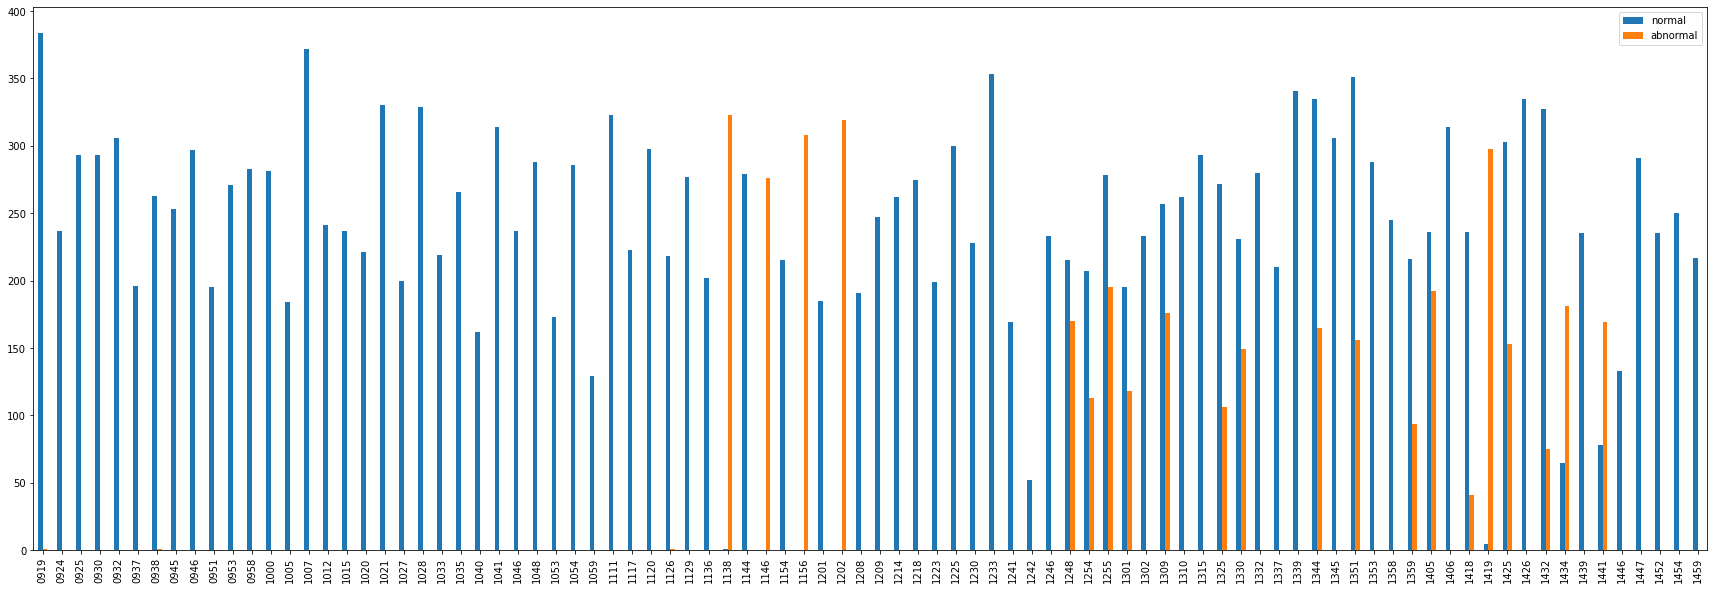

In [ ]:
df_sample = pd.DataFrame.from_dict(dict_seqno, orient='index', columns=['normal', 'abnormal'])
df_sample.plot(kind='bar', figsize=(30,10))

# 3. **시퀀스 내 상태 변화** 샘플 분석

In [ ]:
def get_threshold_sample(seqno):
  threshold_sample=[]
  # 입력된 시퀀스 번호를 사용하는 샘플 리스트
  list_sample = dict_sample[list_seqno[get_seqno_id(seqno)]][:-1]
  # 해당 샘플 리스트에 포함된 프레임 번호 리스트
  list_frmno = list(set([get_frmno(sample) for sample in list_sample]))
  list_frmno.sort()
  for sample in list_sample:
    # 현 프레임 샘플의 상태 확인
    cur_name = os.path.splitext(sample.split('/')[-1])[0]
    path_label = sample.split(cur_name)[0].replace('00_csv','01_label')
    cur_status = check_abnormal(path_label+cur_name+'.json')
    # 다음 프레임 샘플 찾기
    next_name = get_sample_name_pair(cur_name)
    if os.path.exists(path_label+next_name+'.json') == False:
      next_frmno = get_next_frmno(list_frmno, get_frmno(sample))
      next_samples = [s for s in list_sample if '('+next_frmno+')' in os.path.splitext(s.split('/')[-1])[0]]
      for ns in next_samples:
        next_name = os.path.splitext(ns.split('/')[-1])[0]
        #다음 프레임 샘플 상태 확인
        if cur_status != check_abnormal(path_label+next_name+'.json'):
          threshold_sample.append(sample)
          break
    else:
      #다음 프레임 샘플 상태 확인
      if cur_status != check_abnormal(path_label+next_name+'.json'):
        threshold_sample.append(sample)
  threshold_sample = list(set(threshold_sample))
  if len(threshold_sample) > 0:
    print(f"[{seqno}] : {len(threshold_sample)} founded")
    return threshold_sample

In [ ]:
def get_threshold_bbox_temp():
  th_bbox_temp = []
  th_sample = [get_threshold_sample(seqno) for seqno in list_seqno]
  th_sample = list(filter(None, th_sample))
  for sample_by_seq in tqdm(th_sample):
    for sample in sample_by_seq:
      image = create_raw_image(sample)
      label = sample.split('.')[0].replace('00_csv','01_label')+'.json'
      with open(label, "r") as f:
        dict_label = json.load(f)
        for obj in dict_label["annotations"]:
          x = obj["data"]["x"]
          y = obj["data"]["y"]
          w = obj["data"]["width"]
          h = obj["data"]["height"]
          for cy in range(h):
            for cx in range(w):
              coord_x = x+cx
              coord_y = y+cy
              if coord_y < IMG_HEIGHT and coord_x < IMG_WIDTH:
                th_bbox_temp.append(image[coord_y][coord_x])
  return th_bbox_temp

In [ ]:
threshold_bbox_temp = get_threshold_bbox_temp()

[1035] : 45 founded
[1041] : 32 founded
[1117] : 15 founded
[1120] : 51 founded
[1129] : 98 founded
[1138] : 57 founded
[1146] : 97 founded
[1156] : 1 founded
[1202] : 1 founded
[1208] : 25 founded
[1209] : 83 founded
[1223] : 21 founded
[1225] : 98 founded
[1233] : 1 founded
[1301] : 65 founded
[1309] : 41 founded
[1310] : 196 founded
[1324] : 132 founded
[1330] : 73 founded
[1332] : 643 founded
[1337] : 95 founded
[1339] : 160 founded
[1344] : 125 founded
[1351] : 73 founded
[1353] : 181 founded
[1358] : 61 founded
[1359] : 119 founded
[1405] : 154 founded
[1406] : 69 founded
[1411] : 63 founded
[1412] : 53 founded
[1413] : 128 founded
[1418] : 128 founded
[1419] : 73 founded
[1424] : 122 founded
[1426] : 38 founded
[1432] : 172 founded
[1434] : 77 founded
[1439] : 117 founded
[1447] : 67 founded
[1452] : 39 founded
[1453] : 129 founded
[1459] : 1 founded


100%|██████████| 43/43 [55:15<00:00, 77.11s/it]


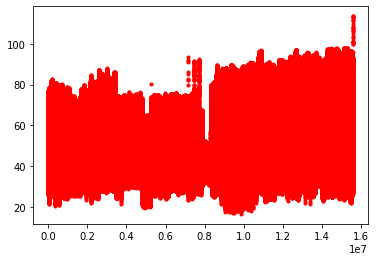

In [ ]:
plt.plot(threshold_bbox_temp, 'r.')